# Logistic Regression on the Titanic Dataset

In [76]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [77]:
train = pd.read_csv('train.csv')


In [78]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## Exploratory Data Analysis

In [79]:
train.isnull().head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,False,False,False,False,False,False,False,False,False,False,True,False
1,False,False,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,True,False
3,False,False,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,True,False


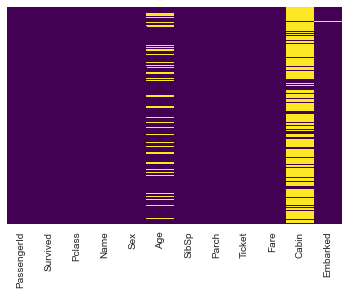

In [80]:
sns.heatmap(train.isnull(),yticklabels=False,cbar=False,cmap='viridis')

If we glimpse at the data, we're missing some age information, we're missing a lot of cabin info and we're missing one row of embarked.
We'll come back to this problem of missing data a little later. But before that lets focus on some exploratory data analysis on a visual level.

In [81]:
sns.set_style('whitegrid')

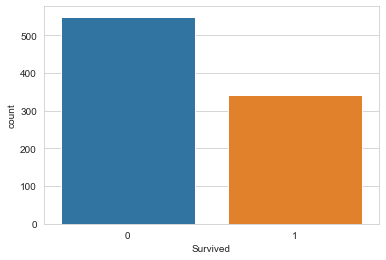

In [82]:
sns.countplot(x='Survived',data=train)

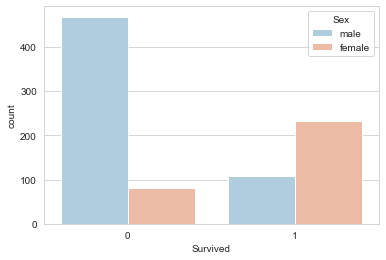

In [83]:
sns.countplot(x='Survived',data=train,hue='Sex',palette='RdBu_r')

Clearly there's a trend here. It looks like people that did not survive were much more likely to be men. While those who survived were twice as likely to be female.

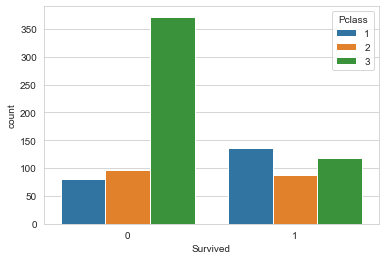

In [84]:
sns.countplot(x='Survived',data=train,hue='Pclass')

Also it looks like the people who did not survive were overwhelmingly part of 3rd class. People that did survive were from the higher classes.

Now lets try and understand the age of the onboard passengers.

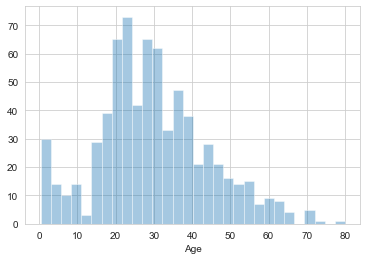

In [85]:
sns.distplot(train['Age'].dropna(),bins=30,kde=False)

There seems to be an interesting bi-modal distribution where there are quite a few young passengers between age 0 and 10. Then the average age tends to be around 20-30.

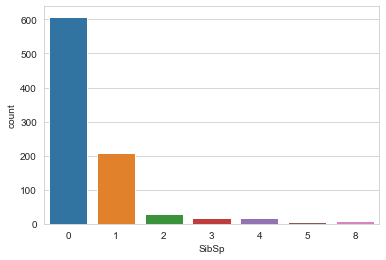

In [86]:
sns.countplot(x='SibSp',data=train)

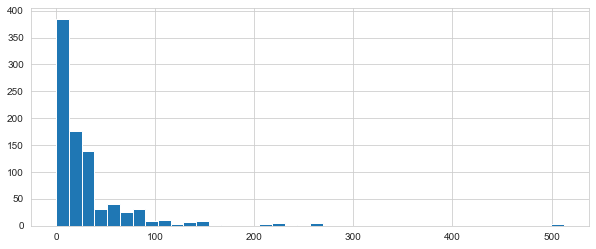

In [87]:
train['Fare'].hist(bins=40,figsize=(10,4))

## Cleaning Data

As we saw earlier there are few columns that are missing some data. We need to clean our dataset before we begin to train our logistic regression model. Lets first try and fill in the missing age values. I'm going to do this by filling in the missing age with the mean age of the passenger class that the passenger belongs to.

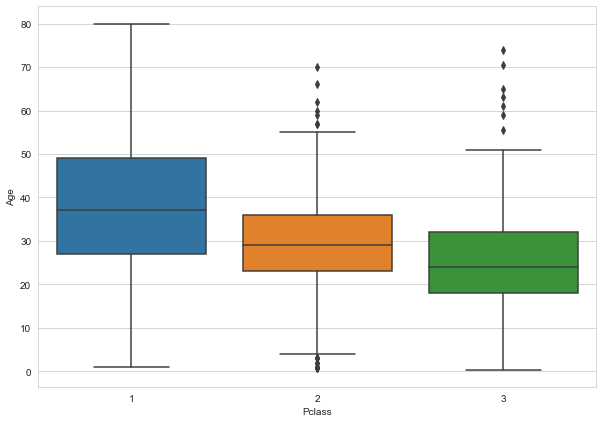

In [88]:
plt.figure(figsize=(10,7))
sns.boxplot(x='Pclass',y='Age',data=train)

In [89]:
train.groupby('Pclass').mean()['Age'].round()

Pclass
1    38.0
2    30.0
3    25.0
Name: Age, dtype: float64

In [90]:
mean_class1 = train.groupby('Pclass').mean()['Age'].round().loc[1]
mean_class2 = train.groupby('Pclass').mean()['Age'].round().loc[2]
mean_class3 = train.groupby('Pclass').mean()['Age'].round().loc[3]

In [91]:
train.loc[train['Pclass']==1,'Age'] = train.loc[train['Pclass']==1,'Age'].fillna(value=mean_class1)
train.loc[train['Pclass']==2,'Age'] = train.loc[train['Pclass']==2,'Age'].fillna(value=mean_class2)
train.loc[train['Pclass']==3,'Age'] = train.loc[train['Pclass']==3,'Age'].fillna(value=mean_class3)

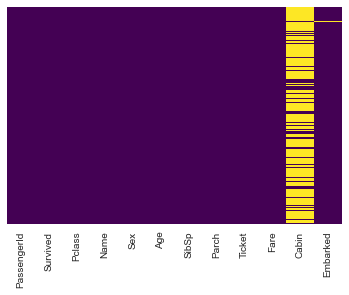

In [92]:
sns.heatmap(train.isnull(),yticklabels=False,cbar=False,cmap='viridis')

I'm going to just drop the cabin column since there's too much missing information.

In [93]:
train.drop('Cabin',axis=1,inplace=True)

In [94]:
train.dropna(inplace=True) # dropping the 1 missing value in Embarked column

I will now convert some of the categorical features in the dataset into dummy variables that our machine learning model can accept.

In [95]:
sex = pd.get_dummies(train['Sex'],drop_first=True)

In [96]:
embark = pd.get_dummies(train['Embarked'],drop_first=True)

In [97]:
train = pd.concat([train,sex,embark],axis=1)

In [98]:
train.head(2)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,male,Q,S
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S,1,0,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C,0,0,0


In [99]:
train.drop(['Sex','Embarked','Name','Ticket'],axis=1,inplace=True)

In [100]:
train.drop('PassengerId',axis=1,inplace=True)

In [101]:
train.head()

,Survived,Pclass,Age,SibSp,Parch,Fare,male,Q,S
0,0,3,22.0,1,0,7.2500,1,0,1
1,1,1,38.0,1,0,71.2833,0,0,0
2,1,3,26.0,0,0,7.9250,0,0,1
3,1,1,35.0,1,0,53.1000,0,0,1
4,0,3,35.0,0,0,8.0500,1,0,1


In [102]:
train.shape

(889, 9)

## Train and build Classifier

In [103]:
X=train.drop(columns=['Survived']).values
y=train['Survived'].values

In [104]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.25, 
                                                    random_state=101)

In [105]:
X_train.shape

(666, 8)

In [106]:
X_test.shape

(223, 8)

In [107]:
from sklearn.linear_model import LogisticRegression

In [108]:
logmodel = LogisticRegression()
logmodel.fit(X_train,y_train)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [109]:
y_pred = logmodel.predict(X_test)

## Accuracy

In [110]:
from sklearn.metrics import accuracy_score
accuracy=accuracy_score(y_test,y_pred)
accuracy

0.820627802690583

## confusion matrix

In [111]:

from sklearn.metrics import confusion_matrix
accuracy=confusion_matrix(y_test,y_pred)
accuracy

array([[126,  10],
       [ 30,  57]], dtype=int64)

In [112]:
from sklearn import metrics
from sklearn.metrics import f1_score
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))
print("F-1 Score:", f1_score(y_test,y_pred))

Accuracy: 0.820627802690583
Precision: 0.8507462686567164
Recall: 0.6551724137931034
F-1 Score: 0.7402597402597402


In [113]:
from sklearn.metrics import classification_report
# Accuracy on Train
print("The Training Accuracy is: ", logmodel.score(X_train, y_train))

# Accuracy on Test
print("The Testing Accuracy is: ", logmodel.score(X_test, y_test))

print(classification_report(y_test,y_pred))

The Training Accuracy is:  0.8003003003003003
The Testing Accuracy is:  0.820627802690583
              precision    recall  f1-score   support

           0       0.81      0.93      0.86       136
           1       0.85      0.66      0.74        87

   micro avg       0.82      0.82      0.82       223
   macro avg       0.83      0.79      0.80       223
weighted avg       0.82      0.82      0.82       223



## Roc Curve

In [114]:
from sklearn.metrics import roc_auc_score
area_roc=roc_auc_score(y_test,y_pred)
area_roc

0.7908215010141988

In [115]:
## plotting roc curve
from sklearn.metrics import roc_curve
fpr,tpr,thresh=roc_curve(y_test,logmodel.predict_proba(X_test)[:,1])

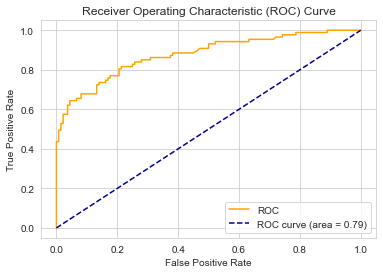

In [116]:
#plt.plot(fpr,tpr)
plt.plot(fpr, tpr, color='orange', label='ROC')
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--',label='ROC curve (area = %0.2f)' % area_roc)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

## Making Predictions

In [126]:
test = pd.read_csv('test.csv')

In [127]:
test.shape

(223, 11)

In [128]:
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [129]:
test_x = test.drop('PassengerId',axis=1)

In [130]:
predictions = logmodel.predict(X_test)

In [131]:
final_prediction = pd.DataFrame({'PassengerId':test['PassengerId'],'Survived':predictions})

In [132]:
final_prediction.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,1
3,895,1
4,896,0
